In [1]:
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_log_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
# Plot configuration
plt.style.use('classic')

In [3]:
# Auxiliary functions

def one_hot_encode_dataset(data: pd.DataFrame) -> pd.DataFrame:
    """
    One-hot encodes categorical variables in the dataset.

    Parameters:
    data (pd.DataFrame): Input dataset.

    Returns:
    pd.DataFrame: Encoded dataset.
    """
    # Identify categorical variables
    categorical_features = data.select_dtypes(include=['object']).columns

    # Apply one-hot encoding to the categorical variables
    encoded_data = pd.get_dummies(data, columns=categorical_features)

    return encoded_data


def map_categorical_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Maps categorical features in the dataset to predefined categories.

    Parameters:
    data (pd.DataFrame): Input dataset.

    Returns:
    pd.DataFrame: Dataset with mapped categorical features.
    """
    # Define mappings
    MSSubClass_mapping = {
        20: '1-STORY 1946 & NEWER ALL STYLES',
        30: '1-STORY 1945 & OLDER',
        40: '1-STORY W/FINISHED ATTIC ALL AGES',
        45: '1-1/2 STORY - UNFINISHED ALL AGES',
        50: '1-1/2 STORY FINISHED ALL AGES',
        60: '2-STORY 1946 & NEWER',
        70: '2-STORY 1945 & OLDER',
        75: '2-1/2 STORY ALL AGES',
        80: 'SPLIT OR MULTI-LEVEL',
        85: 'SPLIT FOYER',
        90: 'DUPLEX - ALL STYLES AND AGES',
        120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
        150: '1-1/2 STORY PUD - ALL AGES',
        160: '2-STORY PUD - 1946 & NEWER',
        180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
        190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
    }

    OverallQual_mapping = {
        10: 'Very Excellent',
        9: 'Excellent',
        8: 'Very Good',
        7: 'Good',
        6: 'Above Average',
        5: 'Average',
        4: 'Below Average',
        3: 'Fair',
        2: 'Poor',
        1: 'Very Poor'
    }

    OverallCond_mapping = OverallQual_mapping

    # Apply mappings
    data['MSSubClass'] = data['MSSubClass'].map(MSSubClass_mapping)
    data['OverallQual'] = data['OverallQual'].map(OverallQual_mapping)
    data['OverallCond'] = data['OverallCond'].map(OverallCond_mapping)

    return data


### Load dataset

In [4]:
# Load train dataset
df = pd.read_csv('../data/train.csv')

# Load test dataset
Xtest = pd.read_csv('../data/test.csv')

# Drop 'Id' column
X_test = Xtest.drop(columns=['Id'])

# Map dataset values to strings
X_test = map_categorical_features(X_test)

# Perform one-hot encoding on the predictor variables
X_test = one_hot_encode_dataset(X_test)

# Convert null values to zero
X_test = X_test.fillna(0)

### Random Forest Regressor Model
Random Forest Regressor analysis to assess the association between the predictor variable ***SalePrice*** and the other variables.

Average R^2 score for 10KFold: 0.8593834297594766
Average RMSLE for 10KFold: 0.15038332298646317


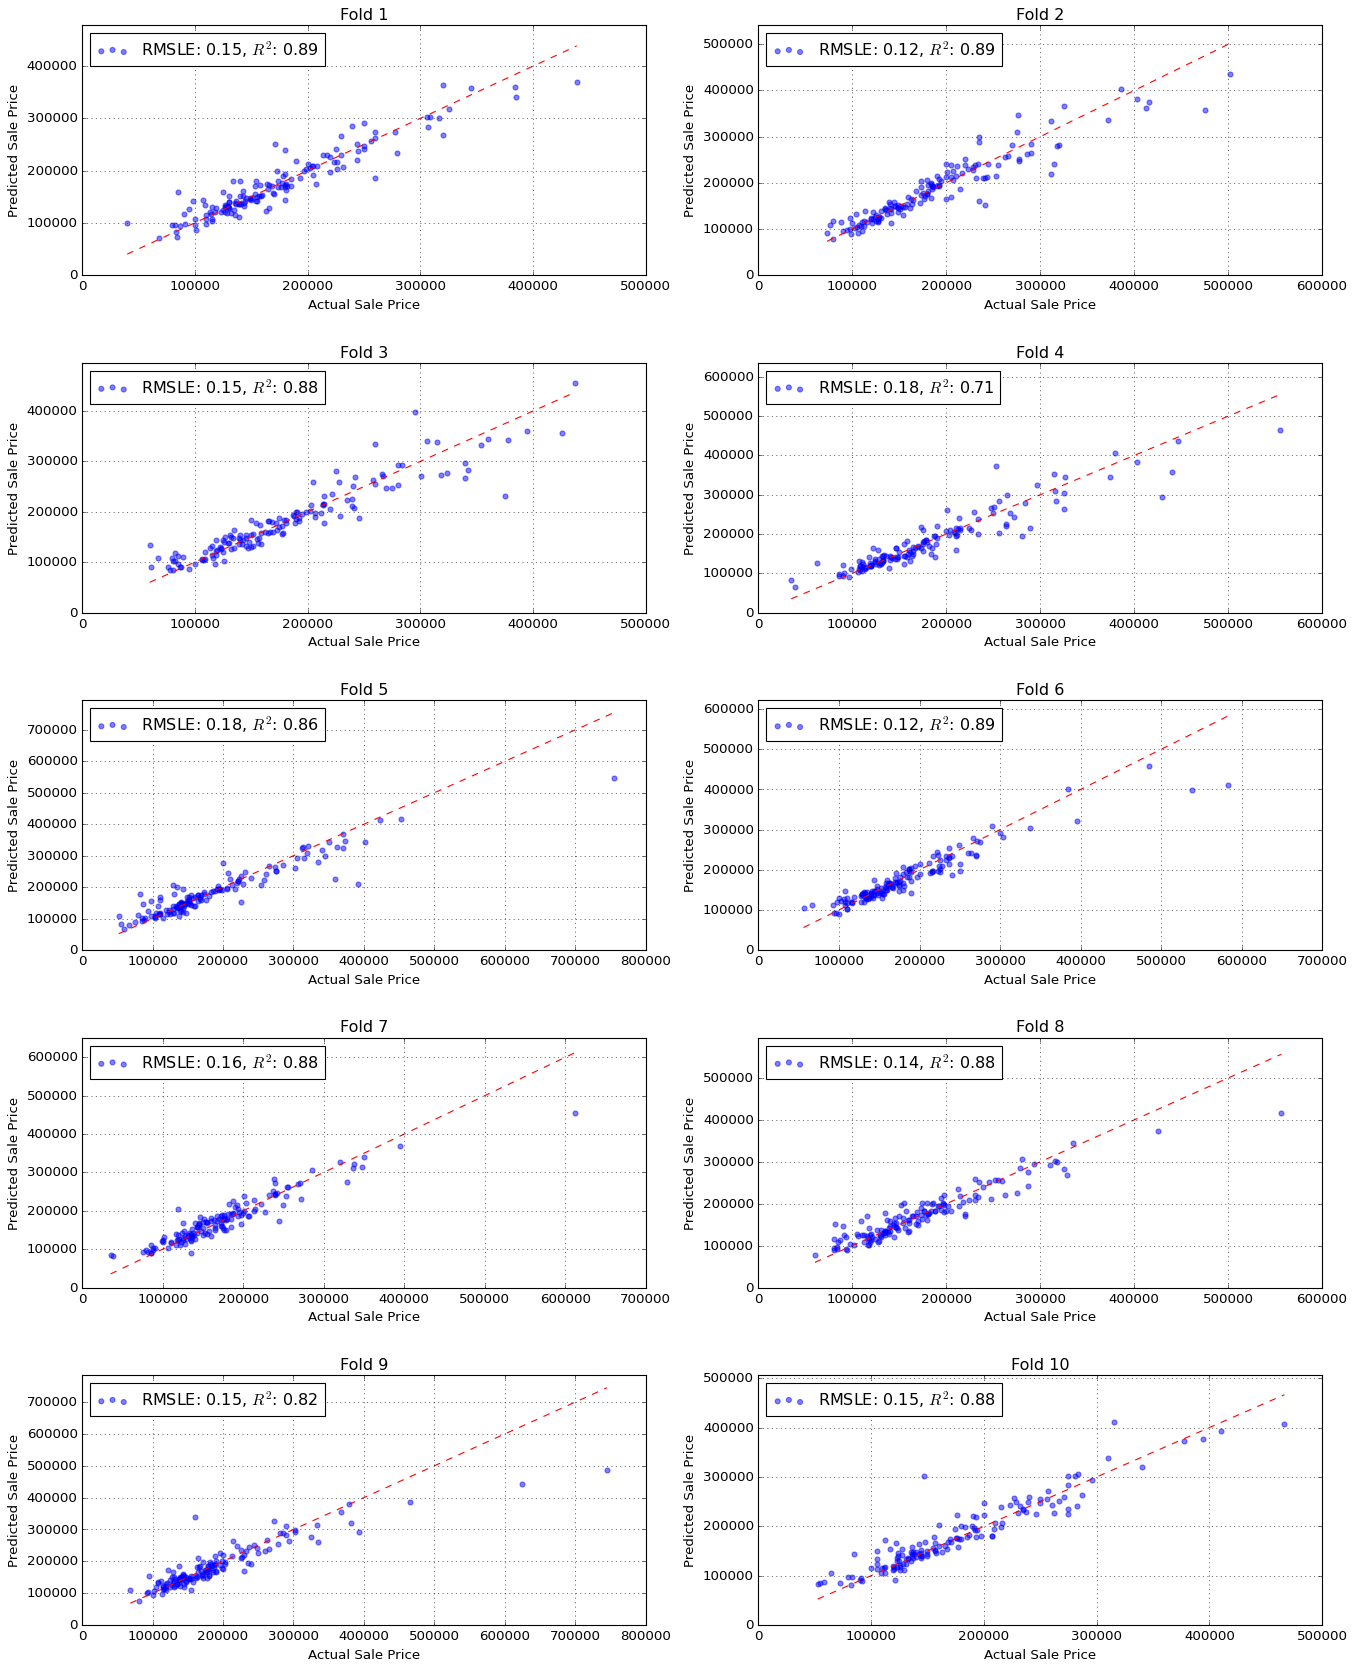

In [5]:
# Define the number of splits for KFold
n_splits = 10

# Initialize the KFold object
kf = KFold(n_splits=n_splits)

# List to store R^2 scores
r2_scores = []

# List to store RMSLE scores
rmsle_scores = []

# Initialize the cumulative predictions matrix
cum_predMatrix = None

# Initialize the figure and axes
fig, axs = plt.subplots(5, 2, figsize=(20, 25))
fig.set_facecolor('white')


# Iterate over KFold splits
for i, (train_index, val_index) in enumerate(kf.split(df)):
    # Split the data into training and validation sets
    X_train, X_val = df.iloc[train_index].drop(columns=['SalePrice', 'Id']), df.iloc[val_index].drop(columns=['SalePrice', 'Id'])
    y_train, y_val = df.iloc[train_index]['SalePrice'], df.iloc[val_index]['SalePrice']
    
    # Map dataset values to strings
    X_train = map_categorical_features(X_train)
    X_val = map_categorical_features(X_val)

    # Perform one-hot encoding on the predictor variables
    X_train = one_hot_encode_dataset(X_train)
    X_val = one_hot_encode_dataset(X_val)

    # Convert null values to zero
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)

    # Create Random Forest Regressor model
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Map features in validation dataset to match the features in training dataset
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

    # Predict on the validation data
    y_pred_val = np.clip(model.predict(X_val), a_min=0, a_max=None)

    # Calculate RMSE
    rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred_val))
    rmsle_scores.append(rmsle)
    
    # Calculate R^2
    r2 = r2_score(y_val, y_pred_val)
    r2_scores.append(r2)
    
    # Plot predicted vs. actual prices for the fold
    row = i // 2
    col = i % 2
    axs[row, col].scatter(y_val, y_pred_val, color='blue', alpha=0.5)
    axs[row, col].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
    axs[row, col].set_title(f'Fold {i+1}')
    axs[row, col].legend([fr'RMSLE: {rmsle:.2f}, $R^2$: {r2:.2f}'], loc='upper left')
    axs[row, col].set_xlabel('Actual Sale Price')
    axs[row, col].set_ylabel('Predicted Sale Price')
    axs[row, col].set_ylim(bottom=0, top= 40000 + max(max(y_val), max(y_pred_val)))
    axs[row, col].grid(True)

    # Generate predictions
    # ----------------------------------------------------------------------------------------------------
    # Map features in test dataset to match the features in training dataset
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # Generate predictions for test dataset 
    predictions = model.predict(X_test)
    
    # Add predictions to the cumulative matrix
    if cum_predMatrix is None:
        cum_predMatrix = predictions
    else:
        cum_predMatrix = np.vstack((cum_predMatrix, predictions))


# Calculate the average R^2 score
avg_r2_score = np.mean(r2_scores)
print("Average R^2 score for 10KFold:", avg_r2_score)

# Calculate the average RMSLE for the validation dataset
avg_rmsle_score = np.mean(rmsle_scores)
print("Average RMSLE for 10KFold:", avg_rmsle_score)

# Adjust layout and plot results
plt.grid(True)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
plt.show()

In [6]:
# Compute the mean of predictions from each KFold model to estimate predictions for the test dataset
predictions = np.mean(cum_predMatrix, axis=0)

# Save predicted prices for submission as CSV file
submission_df = pd.DataFrame({'Id': Xtest['Id'], 
                              'SalePrice': predictions})
submission_df.to_csv('../submission/randForest_submission.csv', index=False)

# Log message
print("Submission file successfully created!")

Submission file successfully created!


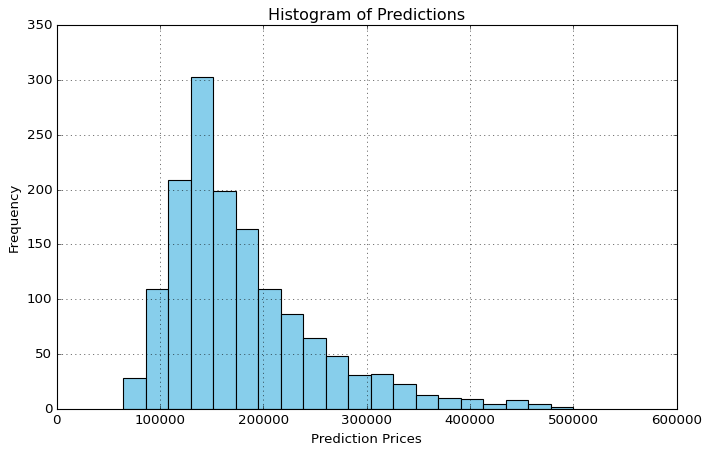

In [7]:
# Plot histogram for prediction values
plt.figure(facecolor='white', figsize=(10, 6))
plt.hist(predictions, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Predictions')
plt.xlabel('Prediction Prices')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()